In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set()

### Load and remove non-run dispenses from log

In [78]:
df = pd.read_csv('20201208_sequoia_dispense_logs.csv')

In [79]:
print(df.shape)
df = df.loc[(df['device_task_view_id'] != 'calibrate')
           & (df['device_task_view_id'] != 'prep_reagents')
           & (df['device_task_top_level'] != 'Calibrate Fluidics')
           & (df['device_task_top_level'] != 'Fluidics Preflight')].copy()

(1392, 26)


### Define Color and Marker map for each valve

In [80]:
valve_color_map = {1:['#CCFF00', '.'],
                  2: ['#CCCC00', 'v'],
                  3: ['#CC9900', 's'],
                  4: ['#CC6600', '1'],
                  5: ['#CC3300', 'P'],
                  6: ['#CC0000', 'X'],
                  7: ['#660000', 'd'],
                  8: ['#663300', '.'],
                  9: ['#666600', 'v'],
                  10:['#669900', '1'],
                  11:['#66CC00', 's'],
                  12:['#66FF00', 'P'],
                  13:['#1A237E', 'X'],
                  14:['#00FF33', 'd'],
                  15:['#00FF00', '.'],
                  16:['#00CC00', 'v'],
                  17:['#009900', 's'],
                  18:['#006600', '1'],
                  19:['#003300', 'P'],
                  20:['#0000FF', 'X']}

### Define function to parse differential pressure sensor data from logs

In [81]:
def parse_diff_pressure(df):
    dispenses_full = []
    for i in range(len(df)):
        dict_string = df['fc_sensor_data'].iloc[i]
        dispenses_full.append(ast.literal_eval(dict_string))

    curves = []
    baselines = []
    peaks = []
    AUCs = []
    gauge_pressures = []
    abs_pressures = []
    lengths = []
    
    for dispense in dispenses_full:
        length = len(dispense)
        single_dispense = []
        try:
            gauge_pressure = dispense[1][1]['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['abs_pressure_bar']
        except KeyError:
            gauge_pressure = dispense[1][1]['state']['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['state']['abs_pressure_bar']
        gauge_pressures.append(gauge_pressure)
        abs_pressures.append(abs_pressure)
        for point in dispense:
            try:
                single_dispense.append(-1 * point[1]['state']['diff_pressure'])
            except KeyError:
                try:
                    single_dispense.append(-1 * point[1]['diff_pressure'])
                except KeyError:
                    print("Key Error: {}".format(point))
                    pass
        try:
            baseline=single_dispense[0]
            baselines.append(baseline)
            for i in range(len(single_dispense)):
                single_dispense[i] = single_dispense[i] - baseline
            peaks.append(max(single_dispense))
            AUCs.append(np.trapz(single_dispense))
            curves.append(single_dispense)
            lengths.append(length)
        
        except IndexError:
            print("IndexError: {}".format(single_dispense))
            curves.append([0])
            baselines.append(0)
            peaks.append(0)
            AUCs.append(0)
            lengths.append(0)

    dict_to_df = {'pressure_curves': curves,
                  'length': lengths,
                 'baseline': baselines,
                 'peak': peaks,
                 'AUC': AUCs,
                 'gauge_pressure': gauge_pressures,
                 'abs_pressure': abs_pressures}
    curve_df = pd.DataFrame(dict_to_df)
    return curve_df



In [82]:
# Concatenate data to original df
curve_df = parse_diff_pressure(df)
df.reset_index(inplace=True, drop=True)
dfs = [df, curve_df]
full_df = pd.concat(dfs, axis=1)

### AUC vs set dispense volume

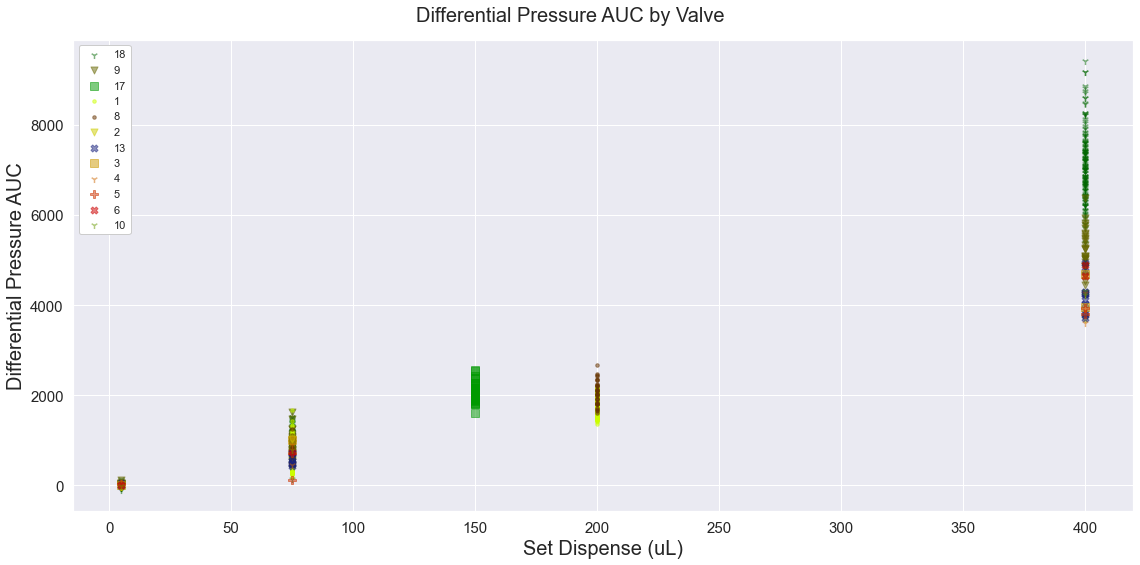

In [98]:
fig, ax = plt.subplots(figsize=(16, 8))
dis_only = full_df.loc[full_df['dispense_type'] == 'reagent'].copy()
valves = dis_only['valve_num'].unique()
for valve in valves:
    valve_df = dis_only.loc[dis_only['valve_num'] == valve].copy()
    ax.scatter(valve_df['volume_ul'], valve_df['AUC'], label="{}".format(valve), 
                         color=valve_color_map[valve][0], marker=valve_color_map[valve][1], s=50, alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Set Dispense (uL)', fontsize=20)
plt.ylabel('Differential Pressure AUC', fontsize=20)
fig.suptitle('Differential Pressure AUC by Valve', fontsize=20)
ax.legend(facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

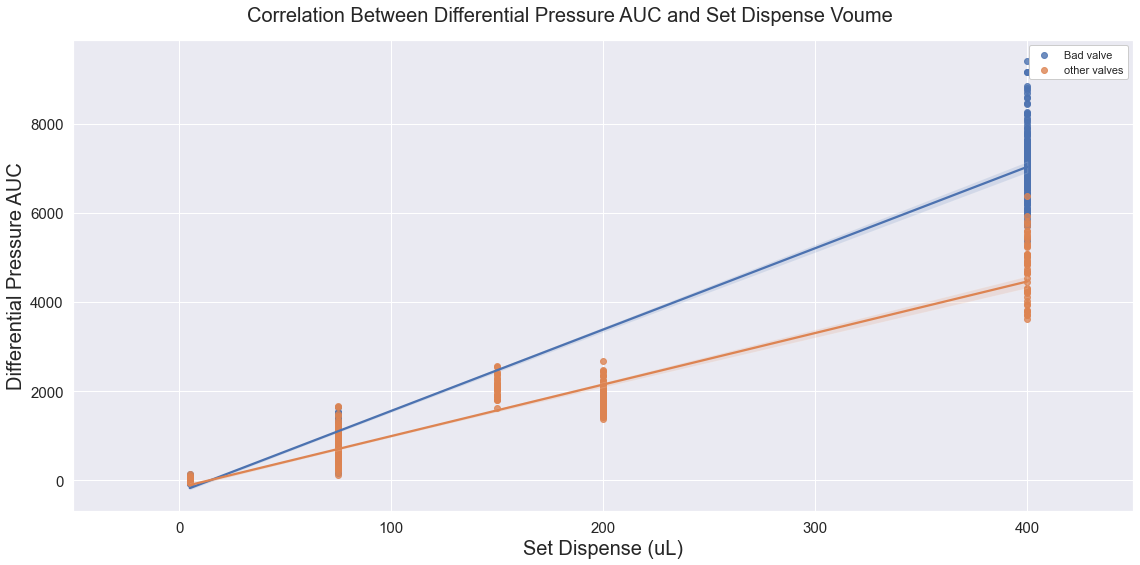

In [105]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(x=dis_only.loc[dis_only['valve_num'] == 18]['volume_ul'], 
            y=dis_only.loc[dis_only['valve_num'] == 18]['AUC'], 
            label = 'Bad valve')
sns.regplot(x=dis_only.loc[dis_only['valve_num'] != 18]['volume_ul'], 
            y=dis_only.loc[dis_only['valve_num'] != 18]['AUC'], 
            label='other valves')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Set Dispense (uL)', fontsize=20)
plt.ylabel('Differential Pressure AUC', fontsize=20)
fig.suptitle('Correlation Between Differential Pressure AUC and Set Dispense Voume', fontsize=20)
ax.set(xlim=(-50, 450))
ax.legend(facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

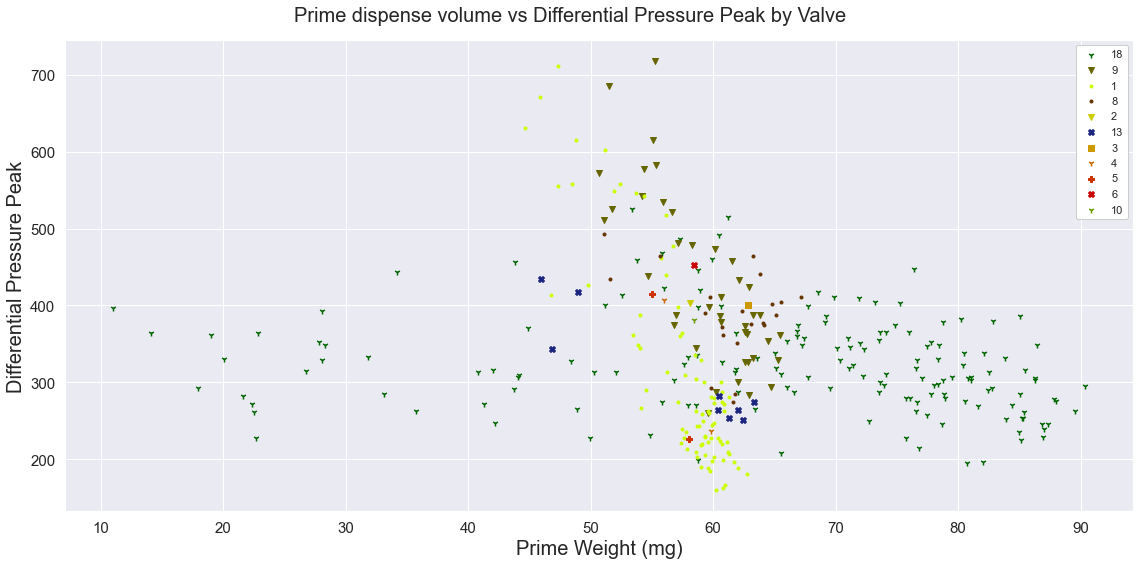

In [97]:
fig, ax = plt.subplots(figsize=(16, 8))
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
valves = primes_df['valve_num'].unique()
for valve in valves:
    valve_df = primes_df.loc[primes_df['valve_num'] == valve].copy()
    ax.scatter(valve_df['weight_mg'], valve_df['peak'], label="{}".format(valve), 
               color=valve_color_map[valve][0], marker=valve_color_map[valve][1])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Prime Weight (mg)', fontsize=20)
plt.ylabel('Differential Pressure Peak', fontsize=20)
fig.suptitle('Prime dispense volume vs Differential Pressure Peak by Valve', fontsize=20)
plt.tight_layout()
ax.legend(facecolor='white', framealpha=1)
plt.show()

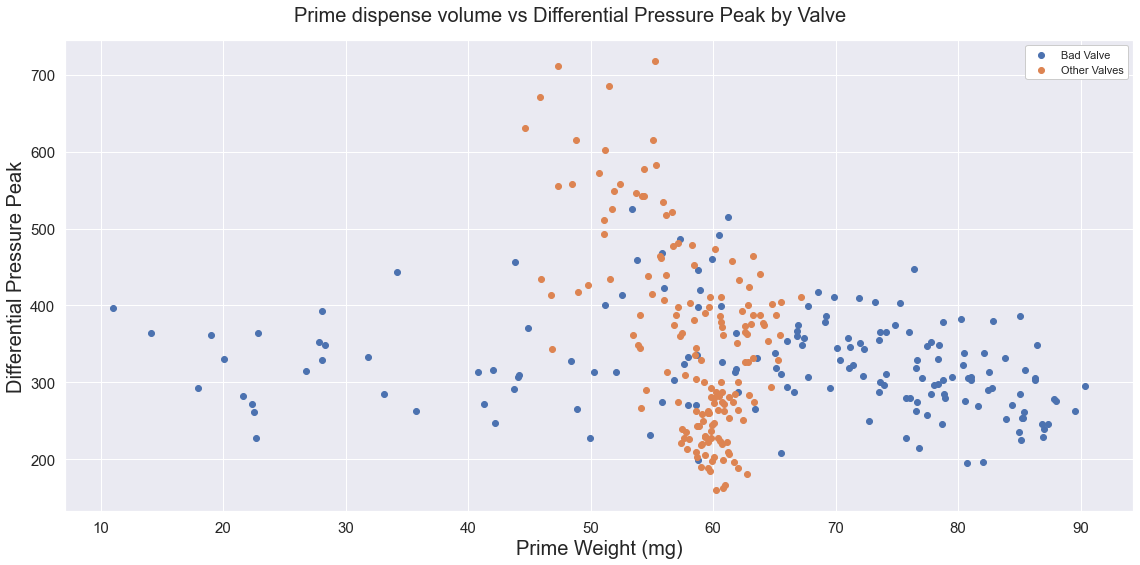

In [107]:
fig, ax = plt.subplots(figsize=(16, 8))
primes_df = full_df.loc[full_df['volume_ul'] == 75].copy()
valve_df = primes_df.loc[primes_df['valve_num'] == 18].copy()
other_df = primes_df.loc[primes_df['valve_num'] != 18].copy()
ax.scatter(valve_df['weight_mg'], valve_df['peak'], label='Bad Valve')
ax.scatter(other_df['weight_mg'], other_df['peak'], label='Other Valves')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Prime Weight (mg)', fontsize=20)
plt.ylabel('Differential Pressure Peak', fontsize=20)
fig.suptitle('Prime dispense volume vs Differential Pressure Peak by Valve', fontsize=20)
plt.tight_layout()
ax.legend(facecolor='white', framealpha=1)
plt.show()

18


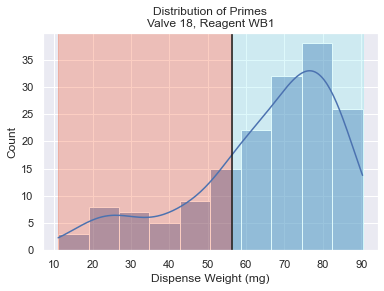

9


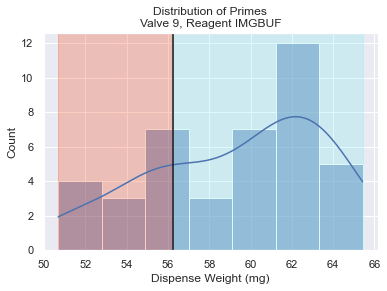

1


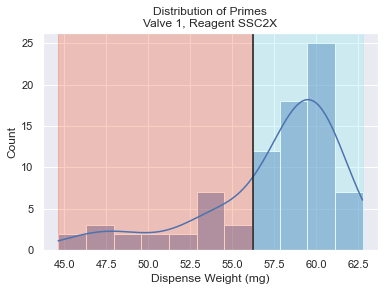

8


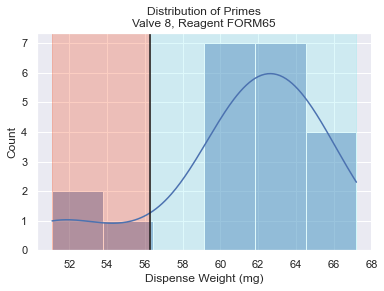

2


C:\Users\ericevje\Anaconda3\envs\cs109a\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


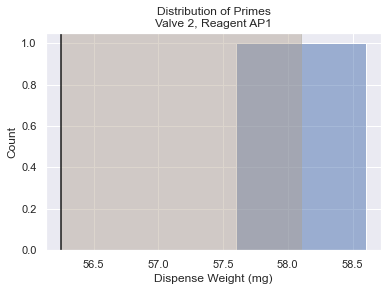

13


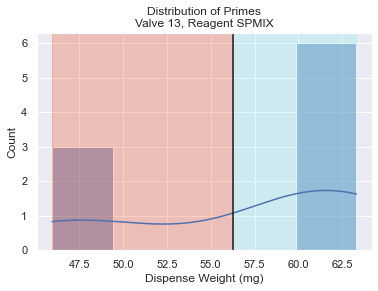

3


C:\Users\ericevje\Anaconda3\envs\cs109a\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


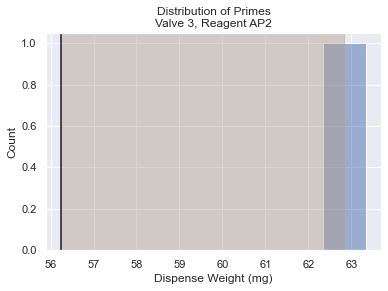

4


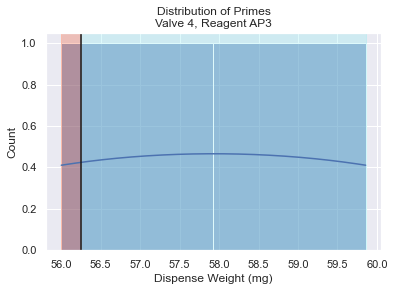

5


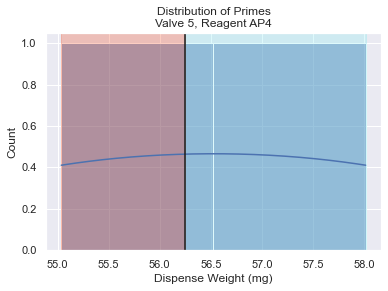

6


C:\Users\ericevje\Anaconda3\envs\cs109a\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


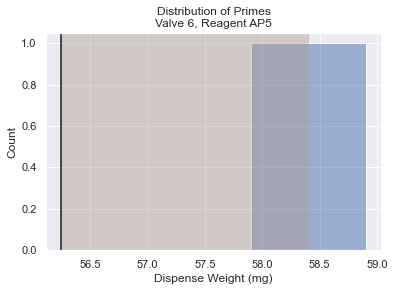

10


C:\Users\ericevje\Anaconda3\envs\cs109a\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


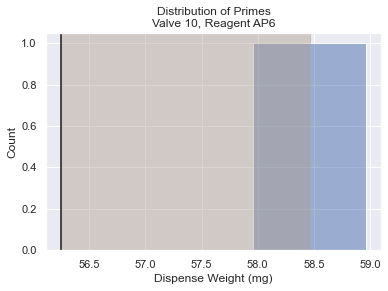

In [115]:
valves = primes_df['valve_num'].unique()
reagents = primes_df['reagent'].unique()

for valve, reagent in zip(valves, reagents):
    print(valve)
    fig, ax = plt.subplots()
    temp_df = primes_df.loc[primes_df['valve_num']==valve]
    sns.histplot(temp_df['weight_mg'], kde=True)
    ax.set(xlabel='Dispense Weight (mg)', title='Distribution of Primes\nValve {}, Reagent {}'.format(valve, reagent))
    ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
    ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
    ax.axvline(75 - 75*.25, color='k')
    plt.show()

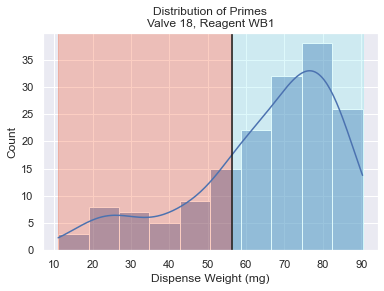

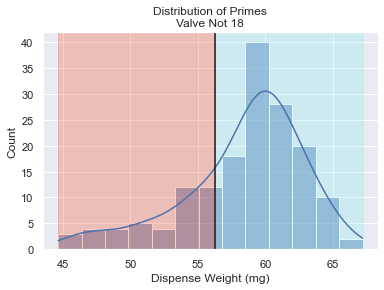

In [116]:
fig, ax = plt.subplots()
temp_df = primes_df.loc[primes_df['valve_num']==18]
sns.histplot(temp_df['weight_mg'], kde=True)
ax.set(xlabel='Dispense Weight (mg)', title='Distribution of Primes\nValve {}, Reagent {}'.format('18', 'WB1'))
ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
ax.axvline(75 - 75*.25, color='k')
plt.show()

fig, ax = plt.subplots()
temp_df = primes_df.loc[primes_df['valve_num']!=18]
sns.histplot(temp_df['weight_mg'], kde=True)
ax.set(xlabel='Dispense Weight (mg)', title='Distribution of Primes\nValve {}'.format('Not 18'))
ax.axvspan(temp_df['weight_mg'].min(), 56.25, alpha=0.25, color='#F43D0C')
ax.axvspan(56.25, temp_df['weight_mg'].max(), alpha=0.25, color='#7DEAF0')
ax.axvline(75 - 75*.25, color='k')
plt.show()

In [121]:
def priming_stats(valve, df):
    bad_valve_df = df.loc[df['valve_num']==valve].copy()
    total_prime_bad = bad_valve_df.shape[0]
    total_bad_prime_bad = bad_valve_df.loc[bad_valve_df['weight_mg'] < 56.25].shape[0]
    total_good_prime_bad = bad_valve_df.loc[bad_valve_df['weight_mg'] >= 56.25].shape[0]
    ratio_bad = total_bad_prime_bad / total_good_prime_bad
    
    print(total_prime_bad, total_bad_prime_bad, total_good_prime_bad, ratio_bad)
    
    other_valve_df = df.loc[df['valve_num']!=valve].copy()
    total_prime_other = other_valve_df.shape[0]
    total_bad_prime_other = other_valve_df.loc[other_valve_df['weight_mg'] < 56.25].shape[0]
    total_good_prime_other = other_valve_df.loc[other_valve_df['weight_mg'] >= 56.25].shape[0]
    ratio_other = total_bad_prime_other / total_good_prime_other
    
    print(total_prime_other, total_bad_prime_other, total_good_prime_other, ratio_other)
    
    
    
retry_ratio(18, primes_df)

165 41 124 0.33064516129032256
162 42 120 0.35


In [87]:
primes_by_valve = primes_df.groupby('valve_num')['weight_mg'].describe().reset_index()
prime_ratio = primes_by_valve.loc[primes_by_valve['valve_num'] == 9]['mean'].iloc[0] / primes_by_valve.loc[primes_by_valve['valve_num'] == 18]['mean'].iloc[0]

AUC_by_valves = dis_only.groupby('valve_num')['AUC'].describe().reset_index()
AUC_ratio = AUC_by_valves.loc[AUC_by_valves['valve_num'] == 9]['mean'].iloc[0] / AUC_by_valves.loc[AUC_by_valves['valve_num'] == 18]['mean'].iloc[0]


print(prime_ratio, AUC_ratio)

0.9129990953508973 0.7106958885430119


{0: 'b', 75: 'g', 400: 'r', 5: 'k', 150: 'y', 200: 'orange'}


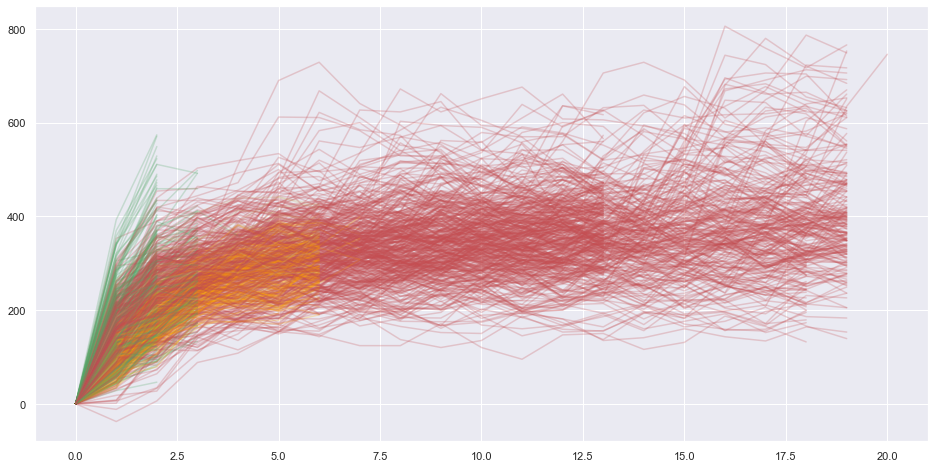

In [88]:
dispenses_full = []
dispense_weight = []
dispense_index = df.index
for i in range(len(df)):
    dict_string = df['fc_sensor_data'].iloc[i]
    dispenses_full.append(ast.literal_eval(dict_string))
    dispense_weight.append(df['volume_ul'].iloc[i])
# print(dispense_index)

all_dispense = []
final_weight_mg = []
for dispense, weight_mg in zip(dispenses_full, dispense_weight):
#     print(dispense)
    single_dispense = []
#     print(counter)
    for point in dispense:
#         print(point[1])
        try:
#             print(-1 * point[1]['state']['diff_pressure'])
            single_dispense.append(-1 * point[1]['state']['diff_pressure'])
        except KeyError:
#             print("didn't work")
            pass
#     print(single_dispense)
    try:
        baseline=single_dispense[0]
        for i in range(len(single_dispense)):
            single_dispense[i] = single_dispense[i] - baseline
        all_dispense.append(single_dispense)
        final_weight_mg.append(weight_mg)
    except IndexError:
#         print("Dispense not long enough for multiple data points")
        all_dispense.append([0])
        final_weight_mg.append(0)

dict_to_df = {'pressure curves': all_dispense,
             'intended dispense volume': final_weight_mg}
curve_df = pd.DataFrame(dict_to_df)
curve_df.head()
values = curve_df['intended dispense volume'].unique()
colors = ['b', 'g', 'r', 'k', 'y', 'orange', 'pink', 'purple', 'lime']
value_color_dict = dict(zip(values, colors))
print(value_color_dict)

fig, ax = plt.subplots(figsize=(16,8))
for i in range(curve_df.shape[0]):
    curve = curve_df['pressure curves'].iloc[i]
#     print(len(curve))
    ax.plot(range(len(curve)), curve, 
            color='{}'.format(value_color_dict[curve_df['intended dispense volume'].iloc[i]]),
           alpha=0.25)

In [89]:
# Find Objective wetting points
full_df['local_ts'] = pd.to_datetime(full_df['local_ts'])
imaging_df = full_df.loc[full_df['device_task_running'] == 'Wet Objective'].copy()
first_row = full_df.iloc[[0]]
last_row = full_df.iloc[[-1]]
imaging_df = pd.concat([first_row, imaging_df, last_row]).reset_index(drop=True)
imaging_df.head()
wetting_ts = imaging_df['local_ts']

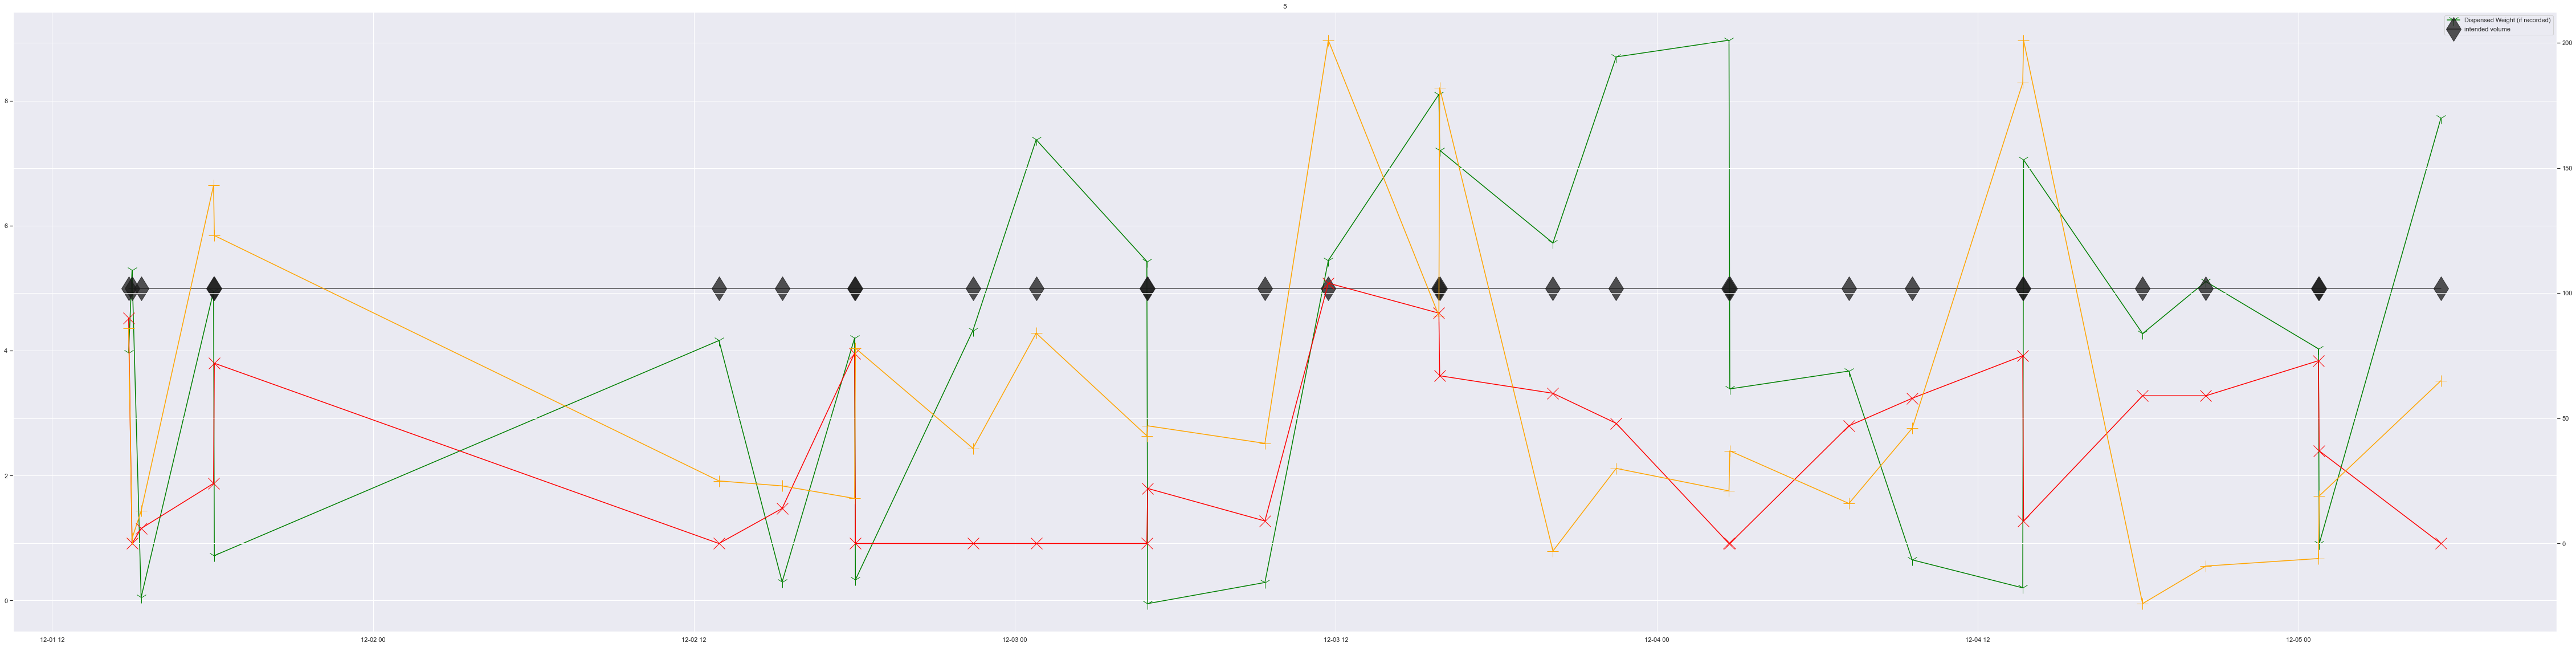

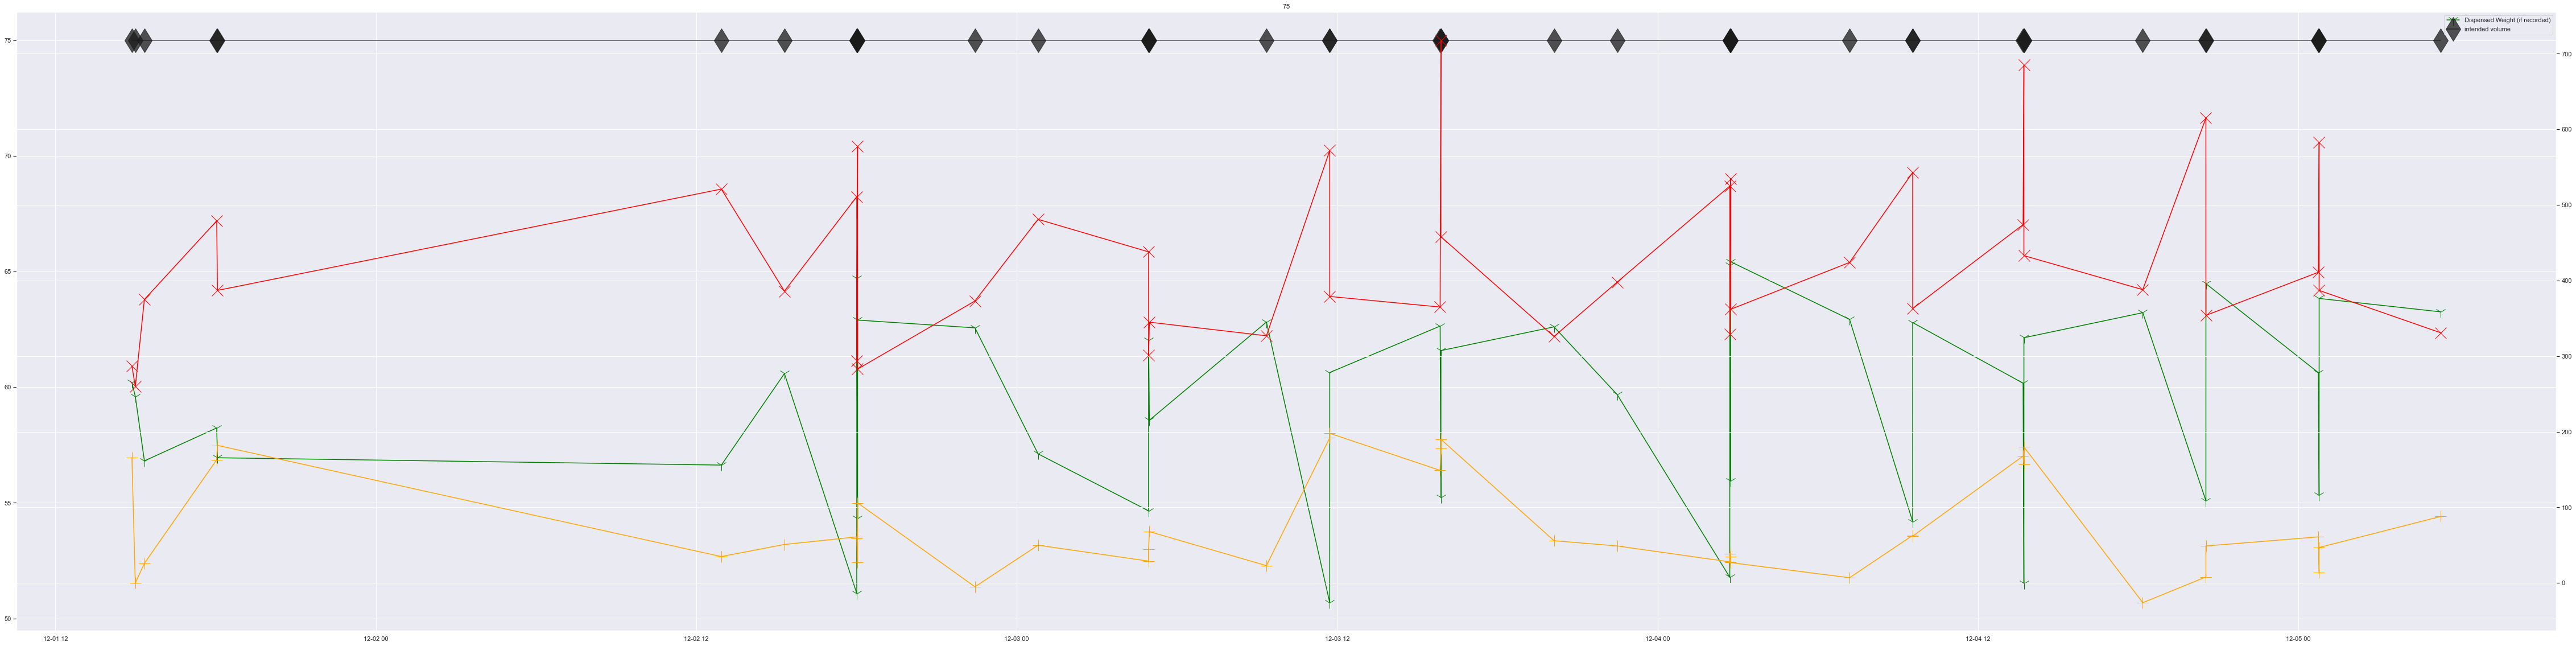

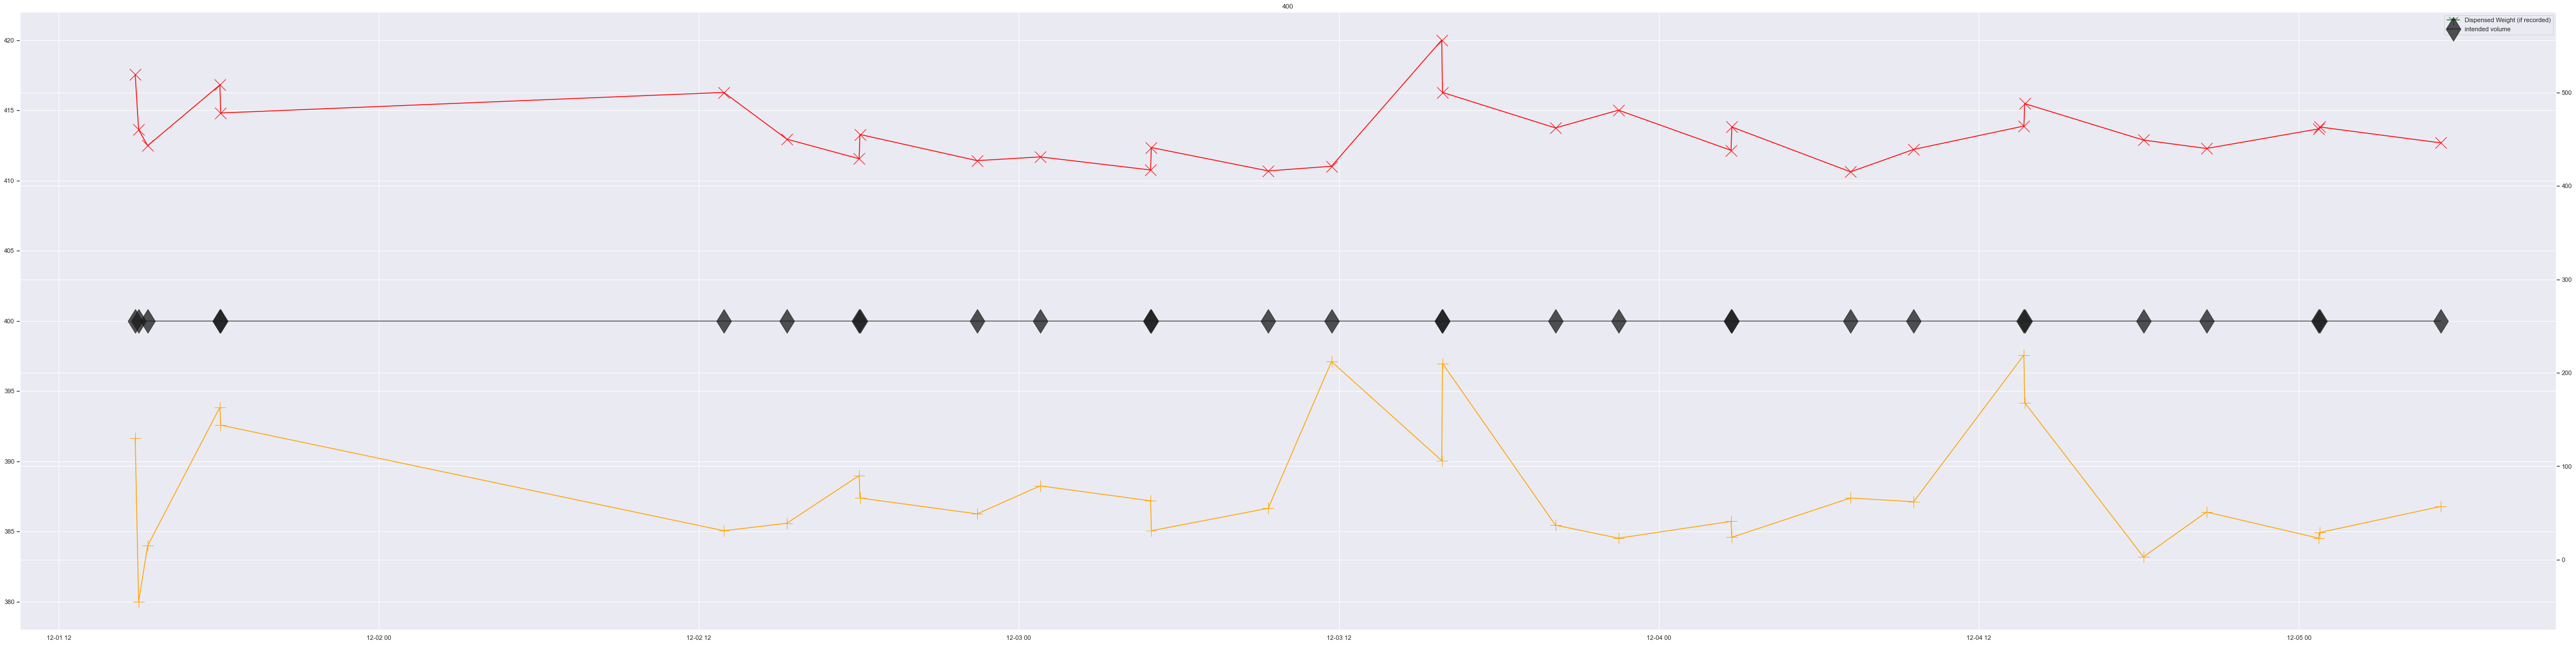

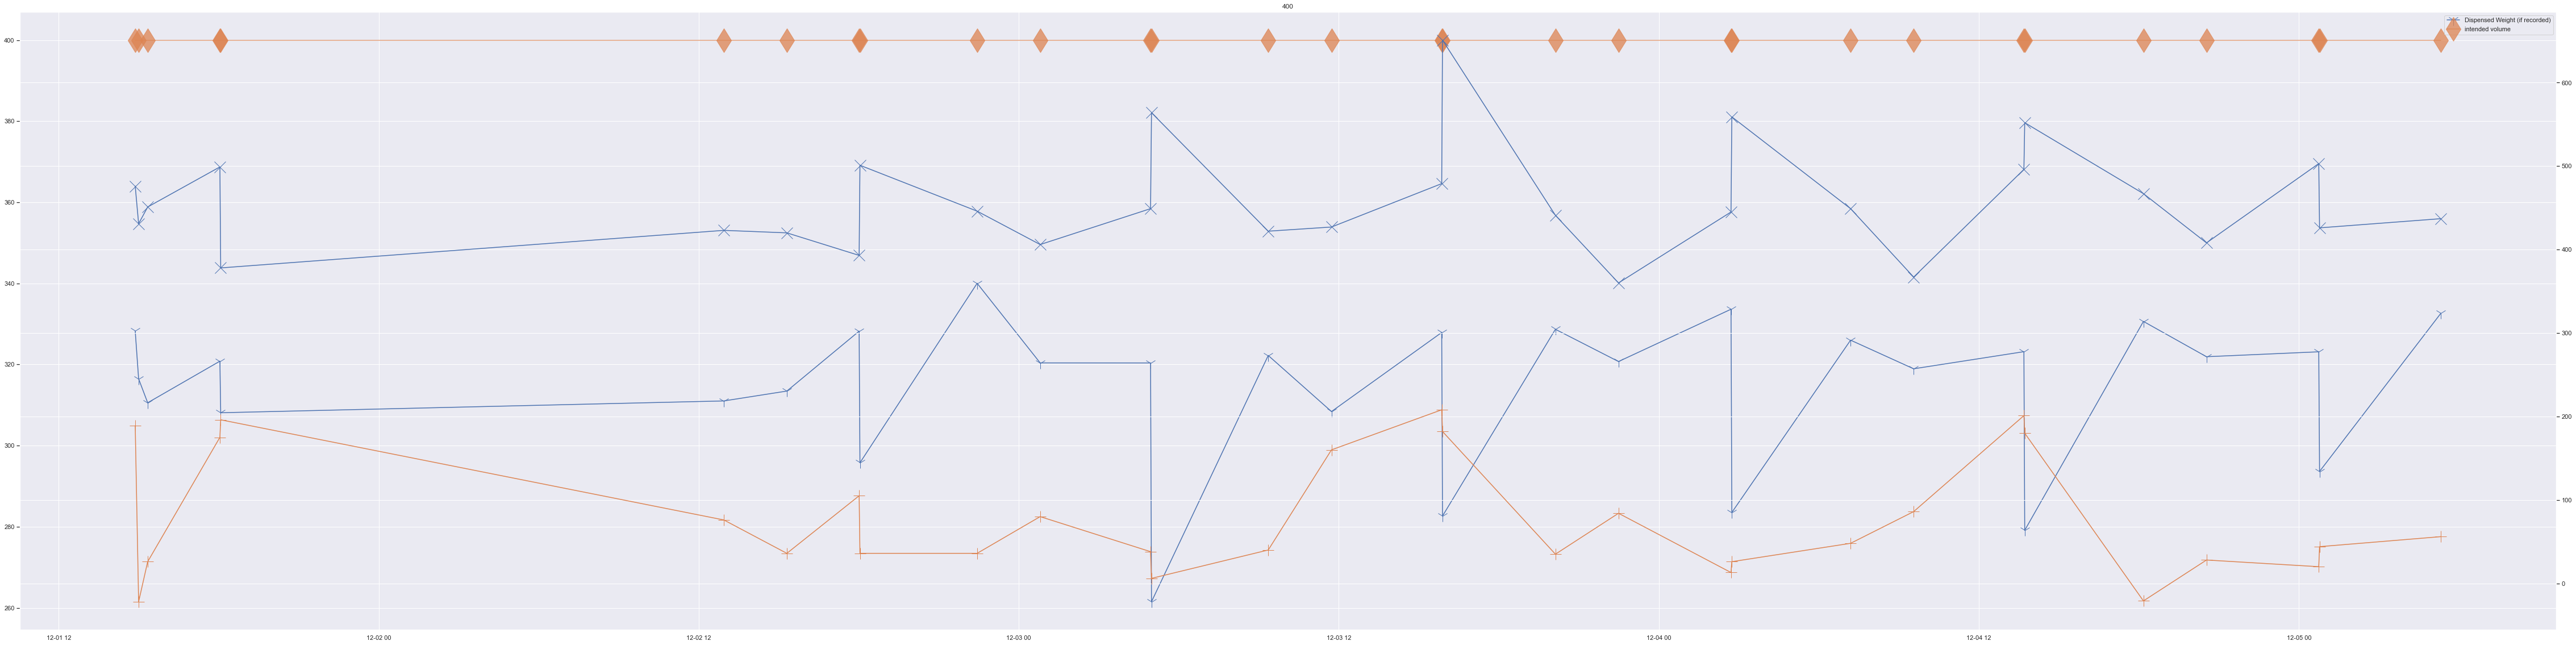

In [127]:
df_18 = full_df.loc[(full_df['valve_num'] == 9) & (full_df['dispense_type'] == 'reagent')].copy()
df_18_flush = full_df.loc[(full_df['valve_num'] == 9) & (full_df['dispense_type'] == 'flush')].copy()
volumes = df_18['volume_ul'].unique()
for volume in volumes:
    temp_df = df_18.loc[df_18['volume_ul'] == volume].copy()
    temp_df.to_csv('time_Series.csv')
    fig, ax = plt.subplots(figsize=(80, 20))
    ax2 = ax.twinx()
#     ax2 = ax.twinx()
    ax2.plot(temp_df['local_ts'], temp_df['peak'], marker='x', label='Diff Pressure Peak', markersize=20, color='red')
    ax2.plot(temp_df['local_ts'], temp_df['baseline'], marker='+', label='Baseline', markersize=20, color='orange')
    ax.plot(temp_df['local_ts'], temp_df['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', markersize=20, color='green')
    ax.plot(temp_df['local_ts'], temp_df['volume_ul'], marker='d', label='intended volume', markersize=30, alpha=0.75, color='k')
#     for i in range(len(wetting_ts) - 1):
#         ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.25)
    ax.set(title='{}'.format(volume))
    ax.legend()
    plt.show()
    
fig, ax = plt.subplots(figsize=(80, 20))
ax2 = ax.twinx()
ax2.plot(df_18_flush['local_ts'], df_18_flush['peak'], marker='x', label='Diff Pressure Peak', markersize=20)
ax2.plot(df_18_flush['local_ts'], df_18_flush['baseline'], marker='+', label='Baseline', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['volume_ul'], marker='d', label='intended volume', markersize=30, alpha=0.75)
# for i in range(len(wetting_ts) - 1):
#     ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.5)
ax.set(title='{}'.format(volume))
sns.set()
ax.legend()
plt.show()
    # ax.set(xscale='log')

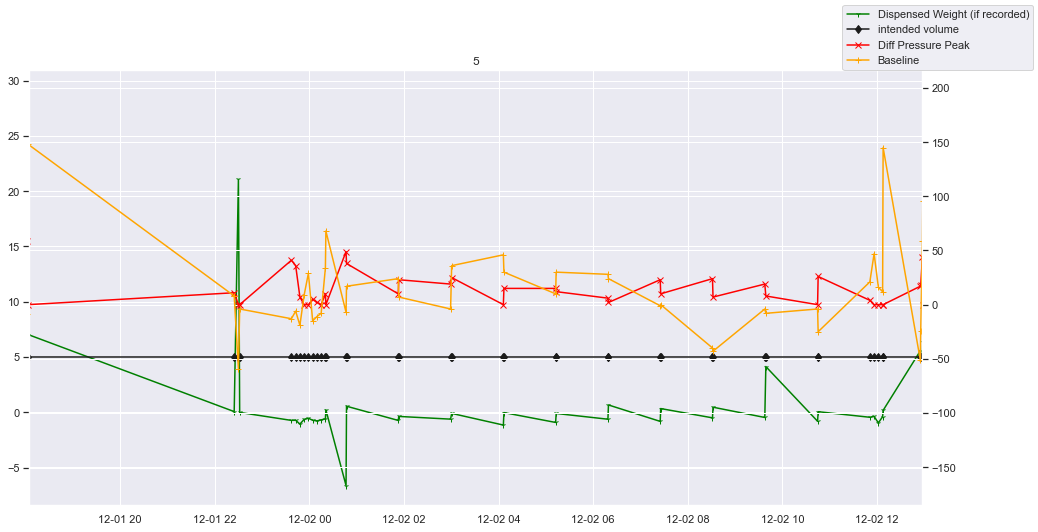

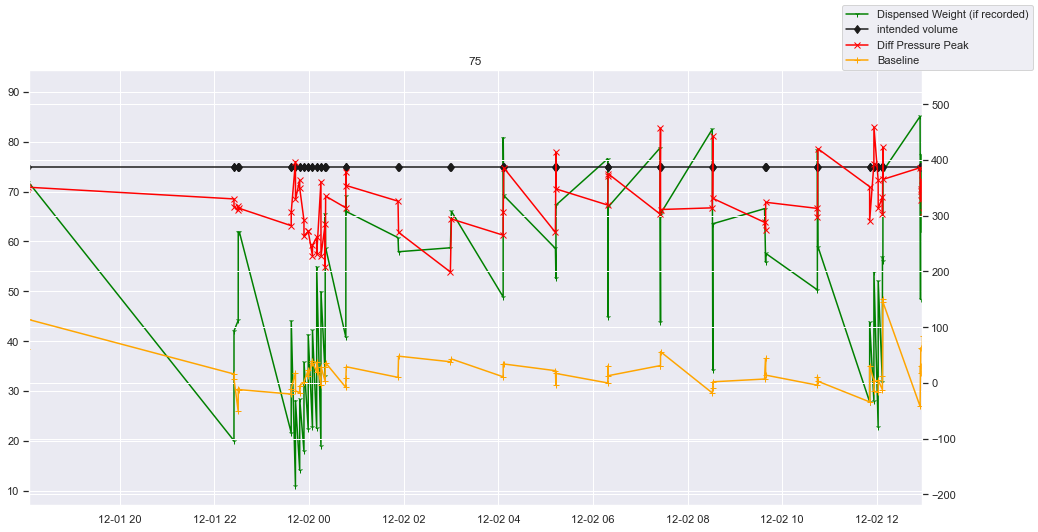

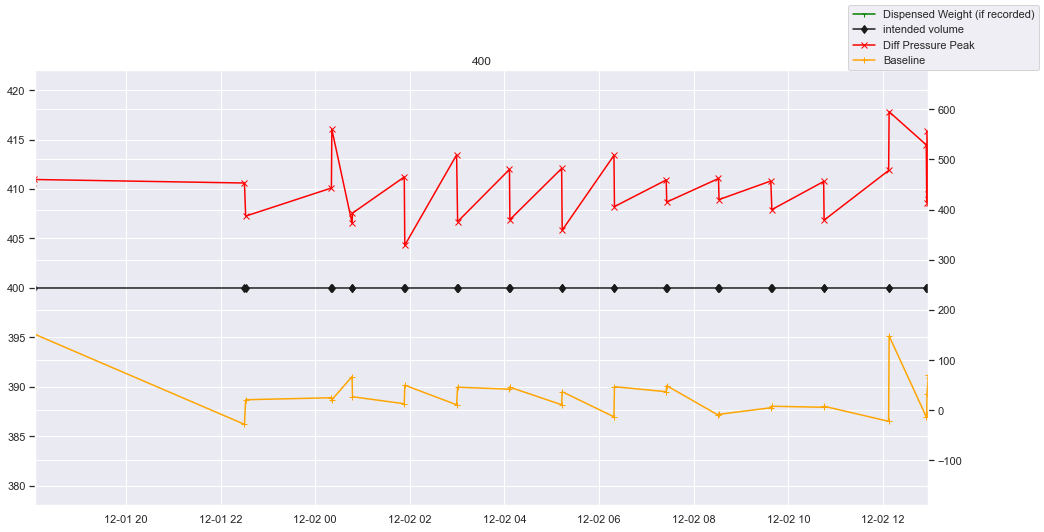

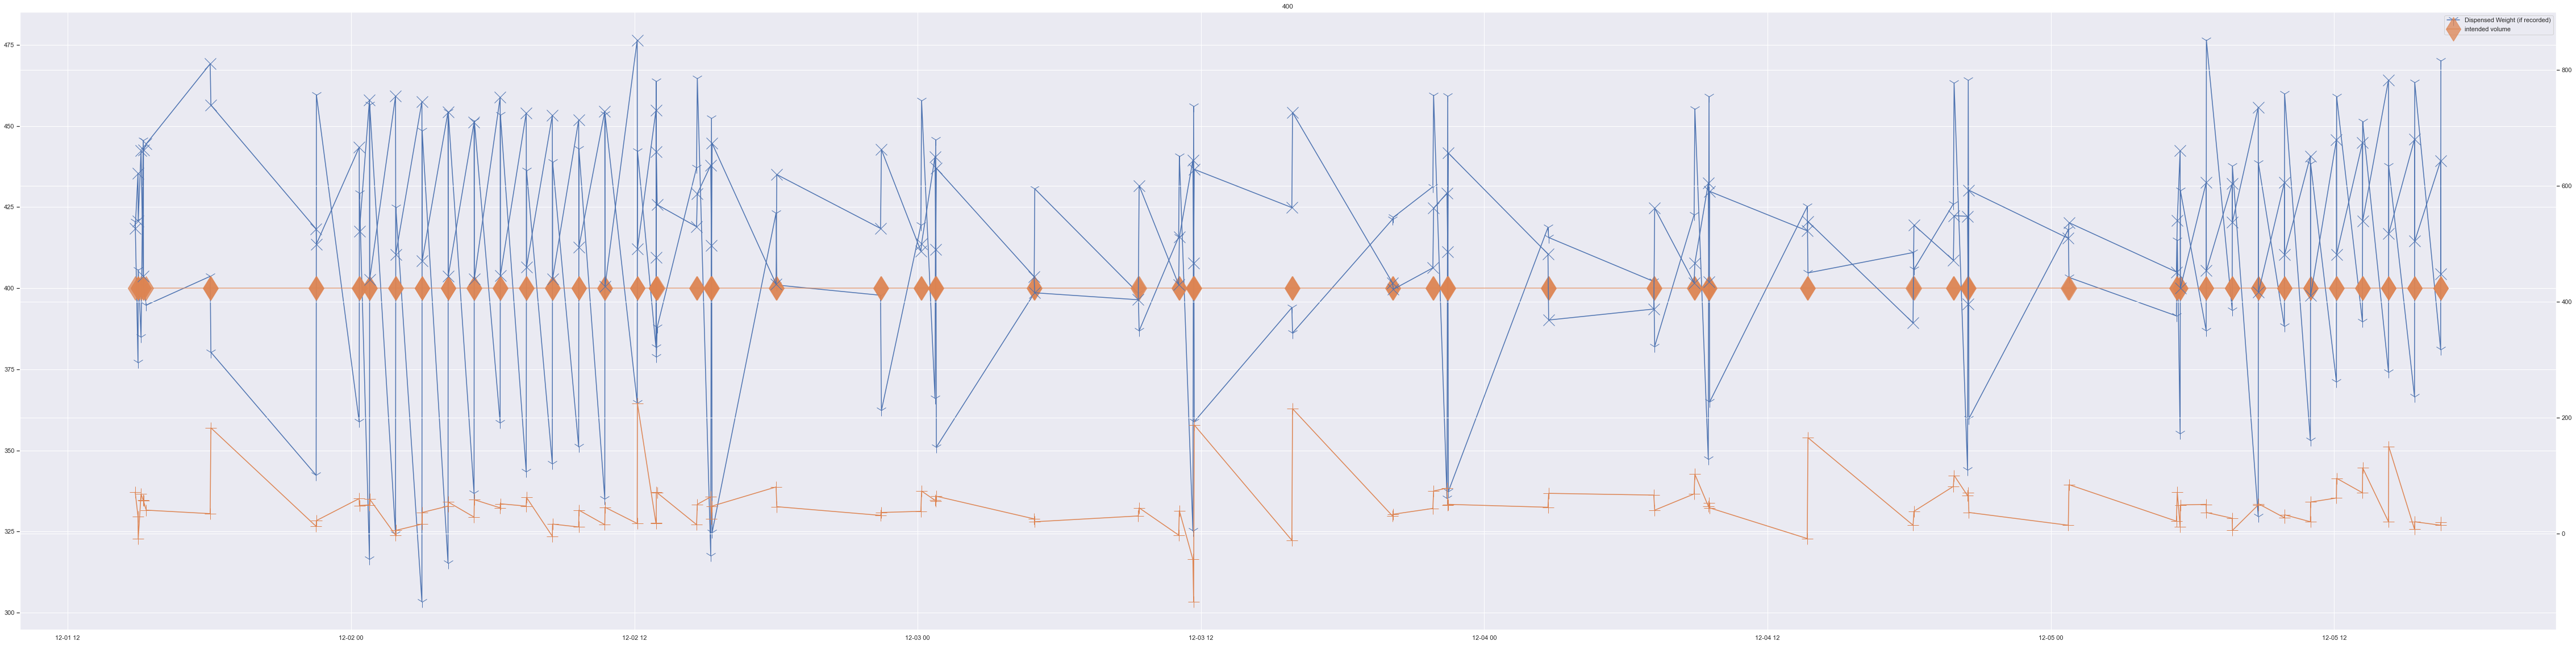

In [125]:
df_18 = full_df.loc[(full_df['valve_num'] == 18) & (full_df['dispense_type'] == 'reagent')].copy()
df_18_flush = full_df.loc[(full_df['valve_num'] == 18) & (full_df['dispense_type'] == 'flush')].copy()
volumes = df_18['volume_ul'].unique()
for volume in volumes:
    temp_df = df_18.loc[df_18['volume_ul'] == volume].copy()
    temp_df.to_csv('time_Series.csv')
    fig, ax = plt.subplots(figsize=(16, 8))
    ax2 = ax.twinx()
#     ax2 = ax.twinx()
    ax2.plot(temp_df['local_ts'], temp_df['peak'], marker='x', label='Diff Pressure Peak', color='red')
    ax2.plot(temp_df['local_ts'], temp_df['baseline'], marker='+', label='Baseline', color='orange')
    ax.plot(temp_df['local_ts'], temp_df['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', color='green')
    ax.plot(temp_df['local_ts'], temp_df['volume_ul'], marker='d', label='intended volume', color='k')
#     for i in range(len(wetting_ts) - 1):
#         ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.5)
    ax.set(title='{}'.format(volume), xlim=(wetting_ts[5], wetting_ts[6]))
    fig.legend()
    plt.show()
    
fig, ax = plt.subplots(figsize=(80, 20))
ax2 = ax.twinx()
ax2.plot(df_18_flush['local_ts'], df_18_flush['peak'], marker='x', label='Diff Pressure Peak', markersize=20)
ax2.plot(df_18_flush['local_ts'], df_18_flush['baseline'], marker='+', label='Baseline', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['weight_mg'], marker='1', label='Dispensed Weight (if recorded)', markersize=20)
ax.plot(df_18_flush['local_ts'], df_18_flush['volume_ul'], marker='d', label='intended volume', markersize=30, alpha=0.75)
# for i in range(len(wetting_ts) - 1):
#     ax.axvspan(wetting_ts[i], wetting_ts[i + 1], alpha=0.5)
ax.set(title='{}'.format(volume))
ax.legend()
plt.show()
    # ax.set(xscale='log')

In [92]:
# Retries by Reagent
# Define Retry as number of times priming happens twice in a row or more prior to dispensing

    